In [1]:
import sys
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append("C:/Users/r02as18/git/gempy/")
import gempy as gp

geo_data = gp.create_data([0,2000,0,2000,0,2000],
                          [100,100,100],
                          path_o = "C:/Users/r02as18/git/gempy/notebooks/input_data/tut_chapter1/simple_fault_model_orientations.csv", # importing orientation (foliation) data
                          path_i = "C:/Users/r02as18/git/gempy/notebooks/input_data/tut_chapter1/simple_fault_model_points.csv") # importing point-positional interface data

gp.set_series(geo_data, {"Fault_Series":'Main_Fault',
                         "Strat_Series": ('Sandstone_2','Siltstone', 'Shale', 'Sandstone_1')},
                          order_series = ["Fault_Series", 'Strat_Series'],
                          order_formations=['Main_Fault',
                                            'Sandstone_2','Siltstone', 'Shale', 'Sandstone_1'], verbose=0)

Can not use cuDNN on context None: cannot compile with cuDNN. We got this error:
b'C:\\Users\\r02as18\\AppData\\Local\\Temp\\try_flags_ml8lb4jb.c:4:19: fatal error: cudnn.h: No such file or directory\r\ncompilation terminated.\r\n'
Mapped name None to device cuda: Quadro M1200 (0000:01:00.0)


In [2]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1,1], output='geology', compile_theano=True, theano_optimizer='fast_compile')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cuda
Precision:  float32
Number of faults:  1


In [19]:
from copy import deepcopy
geo_data_res_stoch = deepcopy(interp_data.geo_data_res)

In [4]:
# create custom 2d grid
nx = 50
nz = 50
geo_data.resolution = [nx, 1, nz]

grid = []
for x in np.linspace(0,2000,nx):
    for y in [1000]:
        for z in np.linspace(0,2000,nz):
            grid.append([x,y,z])
grid = np.array(grid)

lb_init, fb_init = gp.compute_model_at(grid, interp_data)

In [6]:
# load "likelihood" topology graph 
import pickle
G_observed = pickle.load(open("G.p", "rb"))

# Priors

In [3]:
priors = []
priors_names = []

for fmt in geo_data.formations.index:
    if "basement" in fmt:
        continue
    priors.append(ss.norm(0,200))
    priors_names.append(fmt)

In [7]:
priors

In [24]:
from tqdm import tqdm
import warnings

# ABC-REJ

In [34]:
warnings.simplefilter("ignore")

n_iter = 100  # number of desired posterior samples
epsilon = 0.1  # error parameter (if 0.1 will accept jaccard indices of 0.9 or larger)

# storage
lbs = []
fbs = []
graphs = []
centroids = []
jaccards = []
n_sim = 0
prior_samples_storage = []

for i in tqdm(range(n_iter)):
    distance = epsilon + 1  # initiate/reset distance
    while distance > epsilon:
        # draw a new set of priors
        prior_samples = []
        for prior in priors:
            prior_samples.append(prior.rvs())
            
        # change data in gempy interpolator
        for i, fmt in enumerate(priors_names):
            f = interp_data.geo_data_res.interfaces["formation"] == fmt
            interp_data.geo_data_res.interfaces.set_value(f, "Z", geo_data_res_stoch.interfaces[f]["Z"] + (prior_samples[i] / interp_data.rescaling_factor))
        interp_data.update_interpolator()
        
        # compute gempy model
        lb, fb = gp.compute_model_at(grid, interp_data)
        G, C, *_ = gp.topology_compute(geo_data, lb[0], fb, filter_rogue=True)
        
        # compare graphs
        j = gp.topology.compare_graphs(G_observed, G)
        distance = 1 - j  # calc distance
        n_sim += 1  # count total iterations needed to reach n_iter of accepted models
        
    # store accepted models
    graphs.append(G)
    centroids.append(C)
    lbs.append(lb)
    fbs.append(fb)
    prior_samples_storage.append(prior_samples)
    jaccards.append(j)

lbs = np.array(lbs)
prior_samples_storage = np.array(prior_samples_storage)
acc_ratio = n_iter / n_sim

100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:18<00:00,  1.39s/it]


In [36]:
acc_ratio

0.20449897750511248

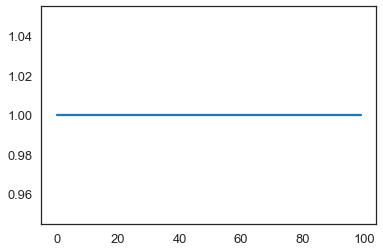

In [44]:
plt.plot(jaccards)

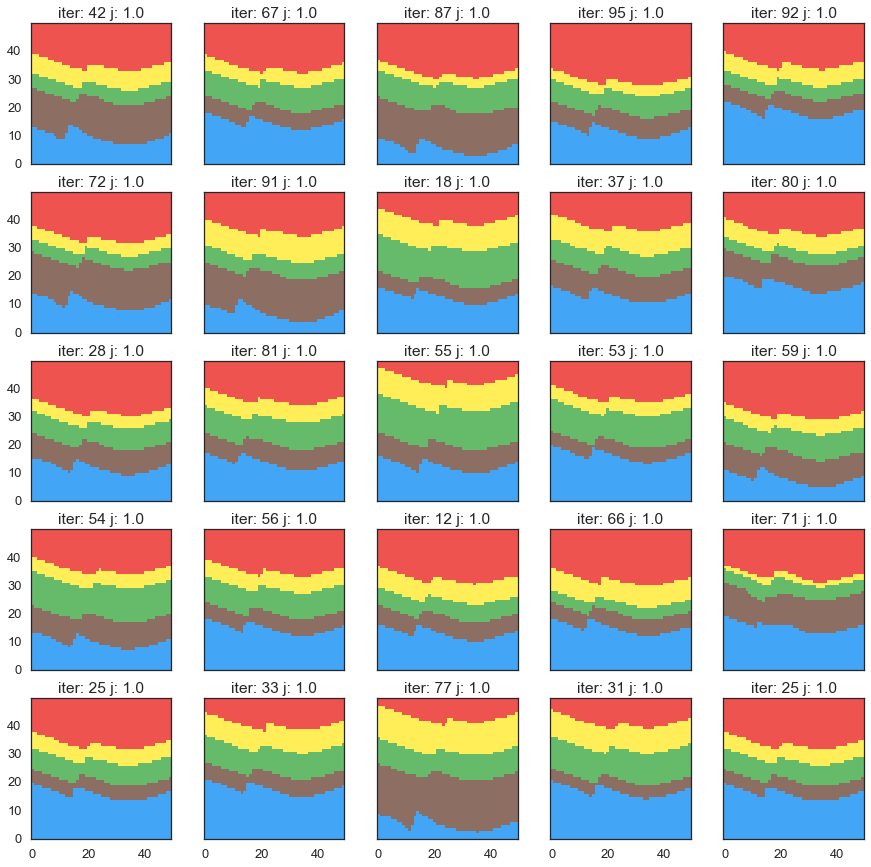

In [39]:
fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(15,15), sharex=True, sharey=True)

for ax in axes.flatten():
    i = np.random.choice(len(lbs))
    ax.imshow(lbs[i][0].reshape(nx,nz).T, origin="lower", cmap=gp.plotting.colors.cmap, norm=gp.plotting.colors.norm)
    # networkx.draw_networkx(graphs[i], centroids[i], ax=ax)
    ax.set_title("iter: "+str(i)+" j: "+str(np.round(jaccards[i], 4)))

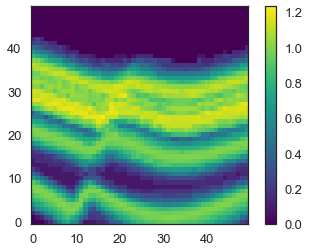

In [43]:
ie_post, iet_post = gp.posterior_analysis.calculate_ie(lbs[:,0,:].astype("int"))
plt.imshow(ie_post.reshape(nx,nz).T, origin="lower", cmap="viridis")
plt.colorbar()